# Sequential Modeling

## Imports

In [102]:
import pandas as pd
import numpy as np
import prophet
import sklearn
import transformers
import plotly.express as px
import plotly.graph_objs as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error

## Electric production time series

### Loading data & plotting

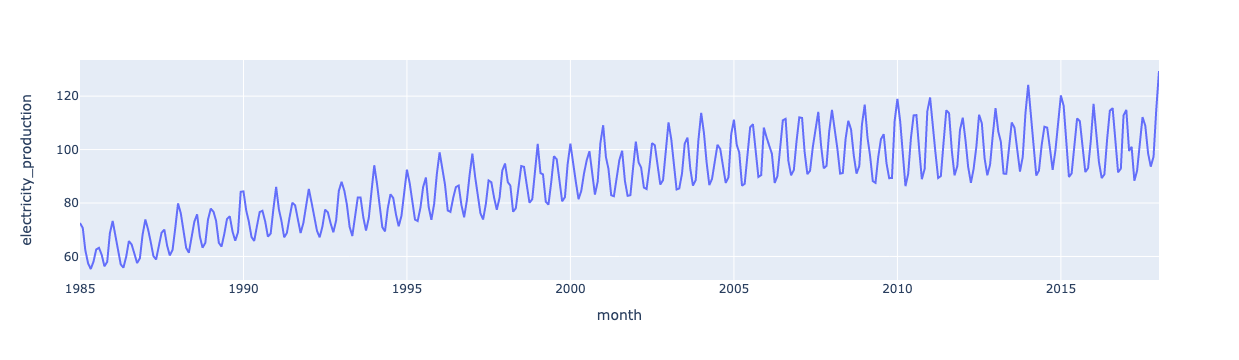

None

,index,month,electricity_production
0,0,1985-01-01,72.5052
1,1,1985-02-01,70.6720
2,2,1985-03-01,62.4502
3,3,1985-04-01,57.4714
4,4,1985-05-01,55.3151
...,...,...,...
392,392,2017-09-01,98.6154
393,393,2017-10-01,93.6137
394,394,2017-11-01,97.3359
395,395,2017-12-01,114.7212


In [95]:
elec = pd.read_csv('Electric_Production.csv', parse_dates=['DATE'], dtype={'IPG2211A2N': 'float'}).sort_values(by='DATE').reset_index()
elec.columns = ['index', 'month', 'electricity_production']
line = px.line(elec, x='month', y='electricity_production')
display(line.show())
display(elec)

### Differencing

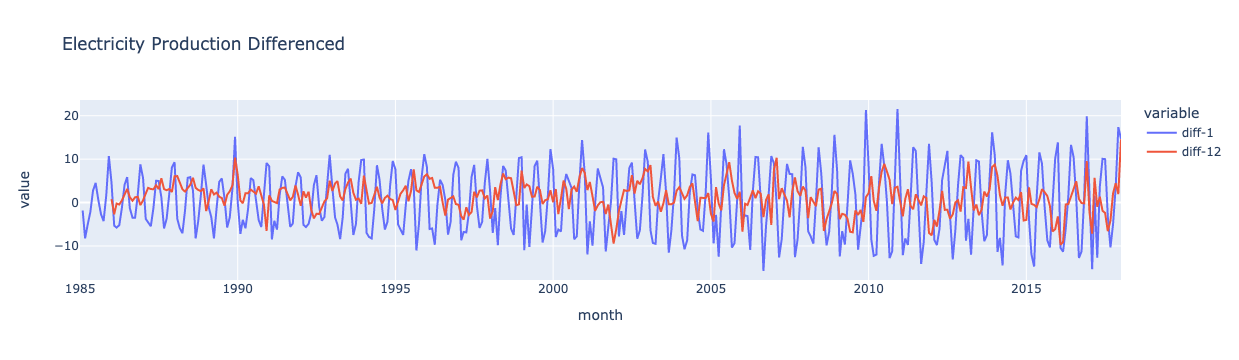

In [96]:
diff_cols = []
for shift in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    # building col
    new_col = f'diff-{shift}'
    diff_cols.append(new_col)
    elec[new_col] = elec['electricity_production'] - elec['electricity_production'].shift(shift)
new_line = px.line(elec, x='month', y=['diff-1', 'diff-12'], title='Electricity Production Differenced')
new_line.show()

### ARIMA

In [161]:
target = 'electricity_production'
model_df = elec[pd.notnull(elec[target])]
model_ts = model_df.set_index('month')[target]
split_date = '2017-01-01'
train_ts = model_ts[model_ts.index <= split_date]
test_ts = model_ts[model_ts.index > split_date]

#### Order 1 Differencing

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



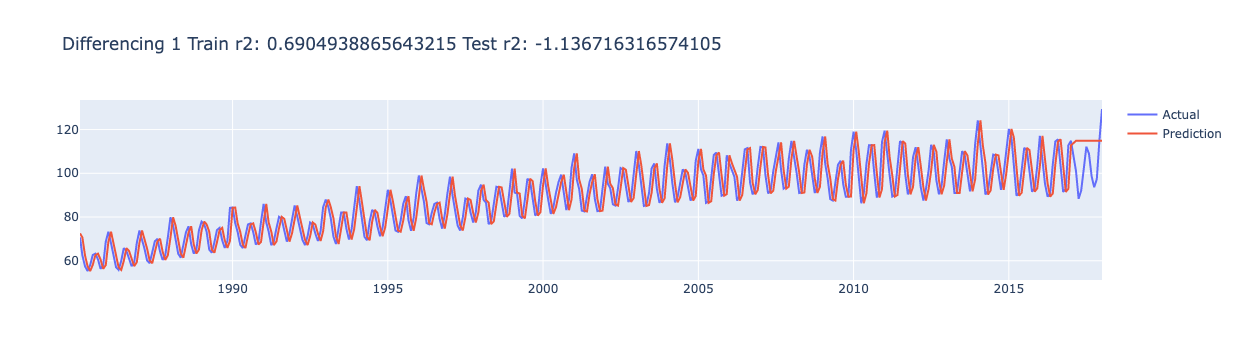

In [168]:
# Train model
# Ignore that we're not doing a regular train test split here, obviously you wouldn't say 'hey my model is great at predicting things it knows'
model = ARIMA(train_ts, order=(0, 1, 0))
results_AR = model.fit()
results_past = pd.DataFrame(results_AR.fittedvalues, columns=['pred']).reset_index()
merged_past = pd.merge(model_df[['month', 'electricity_production']], results_past, on='month')
results_future = pd.DataFrame(results_AR.forecast(steps=30)).reset_index().rename(columns={'index': 'month', 'predicted_mean': 'pred'})
merged_future = pd.merge(model_df[['month', 'electricity_production']], results_future, on='month')
merged = pd.concat([merged_past, merged_future])
merged = merged.drop(0)
train_score = r2_score(merged_past['electricity_production'], results_past['pred'])
test_score = r2_score(merged_future['electricity_production'], merged_future['pred'])
line = go.Figure(data=[
    go.Scatter(x=merged['month'], y=merged['electricity_production'], name='Actual'),
    go.Scatter(x=merged['month'], y=merged['pred'], name='Prediction'),
])
line.update_layout(title=f"Differencing 1 Train r2: {train_score} Test r2: {test_score}")
line.show()

#### Differencing and Moving Average

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



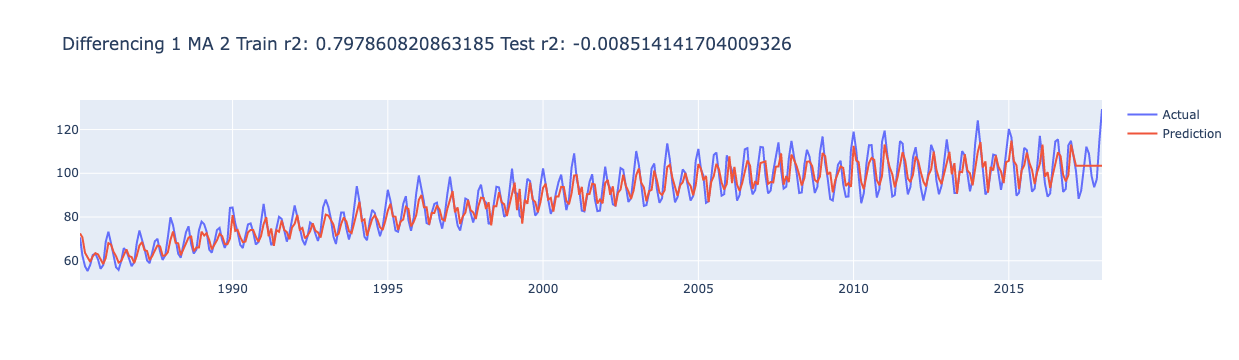

In [173]:
model = ARIMA(train_ts, order=(0, 1, 2))
results_AR = model.fit()
results_past = pd.DataFrame(results_AR.fittedvalues, columns=['pred']).reset_index()
merged_past = pd.merge(model_df[['month', 'electricity_production']], results_past, on='month')
results_future = pd.DataFrame(results_AR.forecast(steps=30)).reset_index().rename(columns={'index': 'month', 'predicted_mean': 'pred'})
merged_future = pd.merge(model_df[['month', 'electricity_production']], results_future, on='month')
merged = pd.concat([merged_past, merged_future])
merged = merged.drop(0)
train_score = r2_score(merged_past['electricity_production'], results_past['pred'])
test_score = r2_score(merged_future['electricity_production'], merged_future['pred'])
line = go.Figure(data=[
    go.Scatter(x=merged['month'], y=merged['electricity_production'], name='Actual'),
    go.Scatter(x=merged['month'], y=merged['pred'], name='Prediction'),
])
line.update_layout(title=f"Differencing 1 MA 2 Train r2: {train_score} Test r2: {test_score}")
line.show()

#### Differencing and Moving Average and Autoregresive

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



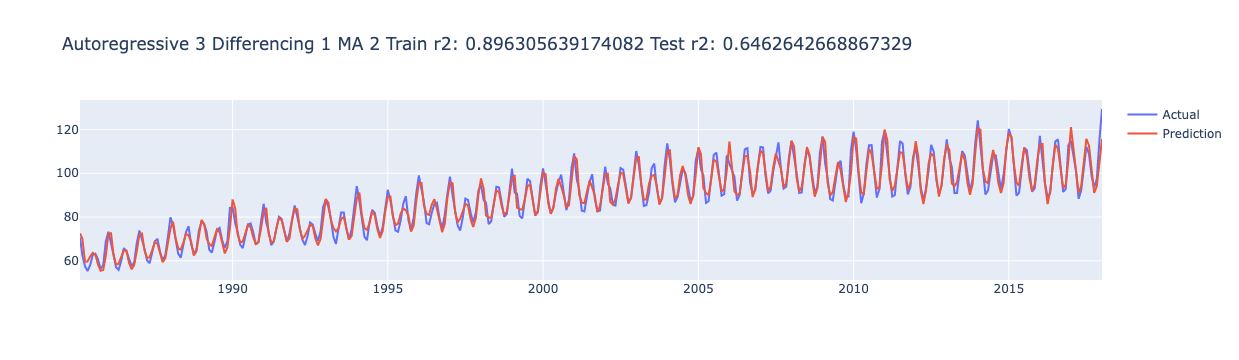

In [174]:
model = ARIMA(train_ts, order=(3, 1, 2))
results_AR = model.fit()
results_past = pd.DataFrame(results_AR.fittedvalues, columns=['pred']).reset_index()
merged_past = pd.merge(model_df[['month', 'electricity_production']], results_past, on='month')
results_future = pd.DataFrame(results_AR.forecast(steps=30)).reset_index().rename(columns={'index': 'month', 'predicted_mean': 'pred'})
merged_future = pd.merge(model_df[['month', 'electricity_production']], results_future, on='month')
merged = pd.concat([merged_past, merged_future])
merged = merged.drop(0)
train_score = r2_score(merged_past['electricity_production'], results_past['pred'])
test_score = r2_score(merged_future['electricity_production'], merged_future['pred'])
line = go.Figure(data=[
    go.Scatter(x=merged['month'], y=merged['electricity_production'], name='Actual'),
    go.Scatter(x=merged['month'], y=merged['pred'], name='Prediction'),
])
line.update_layout(title=f"Autoregressive 3 Differencing 1 MA 2 Train r2: {train_score} Test r2: {test_score}")
line.show()

### Prophet

06:58:06 - cmdstanpy - INFO - Chain [1] start processing
06:58:06 - cmdstanpy - INFO - Chain [1] done processing


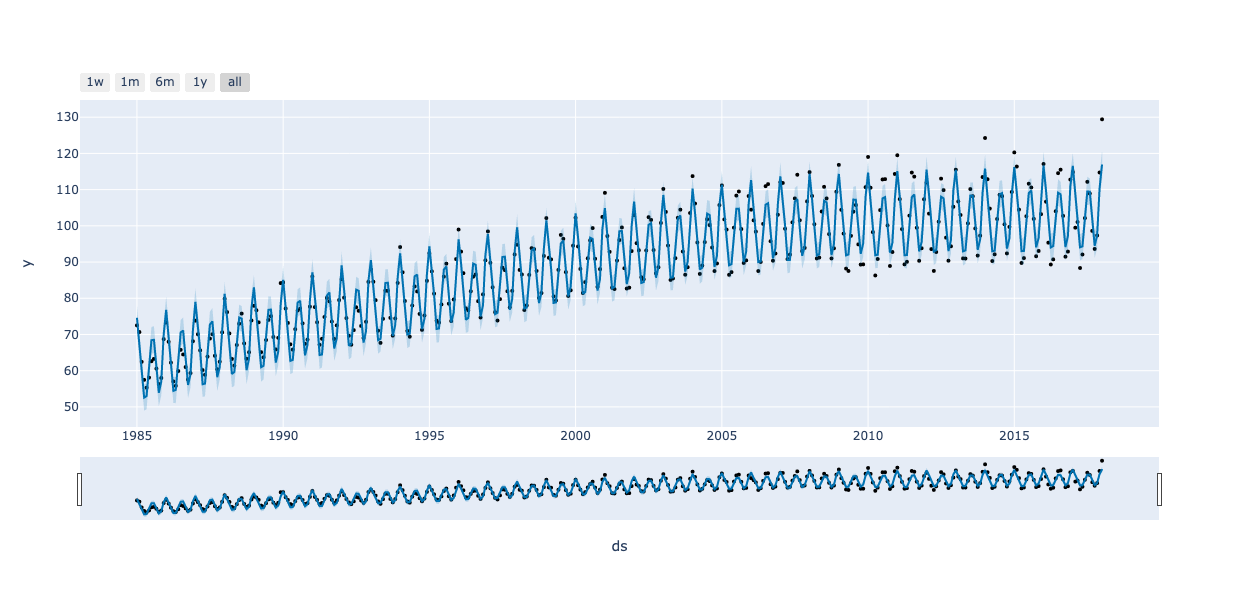

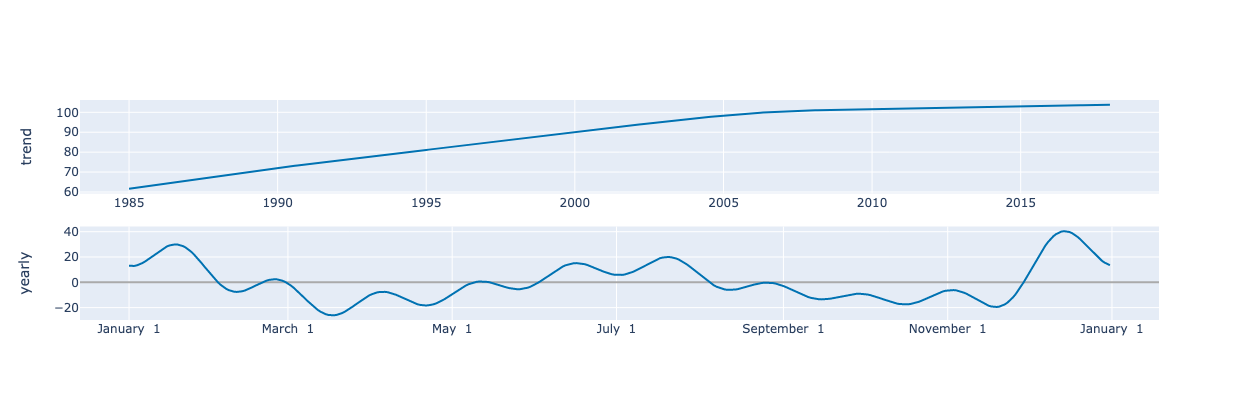

In [175]:
model_df_prophet = model_df.rename(columns={'month': 'ds', 'electricity_production': 'y'})[['ds', 'y']]
m = prophet.Prophet()
m.fit(model_df_prophet)
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)
display(prophet.plot.plot_plotly(m, forecast))
display(prophet.plot.plot_components_plotly(m, forecast))